In [6]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
data_filepath = "../data/steam_reviews.csv"

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, lower, col, count, length, regexp_replace

In [5]:
#spark = SparkSession.builder.appName('games').getOrCreate()
spark = (
    SparkSession.builder.config("spark.sql.debug.maxToStringFields", 100)
    .appName("reviews")
    .getOrCreate()
)

steam_reviews = spark.read.format('csv') \
                    .option('header', 'true') \
                    .load(data_filepath)

# Show the first five records of specific columns in table
steam_reviews.select("app_name","review").show(5)

+--------------------+----------------------------------+
|            app_name|                            review|
+--------------------+----------------------------------+
|The Witcher 3: Wi...|不玩此生遗憾，RPG游戏里的天花板...|
|The Witcher 3: Wi...|       拔DIAO无情打桩机--杰洛特!!!|
|The Witcher 3: Wi...|                           巫师3NB|
|The Witcher 3: Wi...|              One of the best R...|
|The Witcher 3: Wi...|                              大作|
+--------------------+----------------------------------+
only showing top 5 rows



In [5]:
# Stopwords list
stopwords = [
    'the', 'and', 'to', 'of', 'it', 'in', 'or', 'is', 'an', 'as',
    'on', 'a', 'i', 'this', 'for', 'with', 'are', 'you', 'have', 'that', 'be', 'but',
    'by', 'not', 'if', 'they', 'from', 'at', 'my', 'there', 'so', 'we', 'will', 'can',
    'all', 'your', 'would', 'their', 'what', 'which', 'when', 'me', 'more', 'out', 'up','game'
]

In [6]:
english_reviews = steam_reviews.where(steam_reviews['language'] == "english").select("app_id", "app_name", "review")

In [10]:
english_reviews.show(5)

+------+--------------------+--------------------+
|app_id|            app_name|              review|
+------+--------------------+--------------------+
|292030|The Witcher 3: Wi...|One of the best R...|
|292030|The Witcher 3: Wi...|good story, good ...|
|292030|The Witcher 3: Wi...|            dis gud,|
|292030|The Witcher 3: Wi...|favorite game of ...|
|292030|The Witcher 3: Wi...|Why wouldn't you ...|
+------+--------------------+--------------------+
only showing top 5 rows



In [32]:
words_in_reviews = english_reviews.select("app_id", "app_name", explode(split(lower(col("review")), "\W+")).alias("word"))
filtered_words_in_reviews = words_in_reviews.where(~col("word").isin(stopwords) & (length(col("word")) >= 3) &  ~col("word").rlike("\d"))
filtered_words = filtered_words_in_reviews.select("word")

In [34]:
filtered_words.show(20)

+----------+
|      word|
+----------+
|       one|
|      best|
|       rpg|
|      time|
|    worthy|
|       any|
|collection|
|      good|
|     story|
|      good|
|  graphics|
|      lots|
|       dis|
|       gud|
|  favorite|
|      time|
|      cant|
|      wait|
|    nexgen|
|  versiion|
+----------+
only showing top 20 rows



In [37]:
filtered_word_count = filtered_words.groupBy("word").agg(count("*").alias("count")).orderBy(col("count").desc())

In [38]:
# top_words = filtered_word_count.show(20) # VERY SLOW

top_words = filtered_word_count.limit(1000).collect()

In [39]:
print(top_words[:30])

[Row(word='fun', count=1505443), Row(word='good', count=1499515), Row(word='play', count=1092099), Row(word='great', count=1051076), Row(word='like', count=1046191), Row(word='very', count=925678), Row(word='just', count=896658), Row(word='its', count=831203), Row(word='one', count=771972), Row(word='best', count=745357), Row(word='games', count=739453), Row(word='get', count=730989), Row(word='really', count=691124), Row(word='was', count=678433), Row(word='time', count=651351), Row(word='played', count=593832), Row(word='love', count=575094), Row(word='has', count=541660), Row(word='hours', count=489063), Row(word='amazing', count=472594), Row(word='ever', count=462404), Row(word='much', count=453824), Row(word='playing', count=451289), Row(word='even', count=445766), Row(word='some', count=430616), Row(word='friends', count=412938), Row(word='story', count=401023), Row(word='still', count=398962), Row(word='only', count=377360), Row(word='recommend', count=368852)]


In [46]:
word_freq = {}
for i in range(1, 51):
  row = top_words[i]
  word = row['word']
  count = row['count']
  print(str(i) + ":", word, "(" + str(count) + ")")
  word_freq[word] = count

1: good (1499515)
2: play (1092099)
3: great (1051076)
4: like (1046191)
5: very (925678)
6: just (896658)
7: its (831203)
8: one (771972)
9: best (745357)
10: games (739453)
11: get (730989)
12: really (691124)
13: was (678433)
14: time (651351)
15: played (593832)
16: love (575094)
17: has (541660)
18: hours (489063)
19: amazing (472594)
20: ever (462404)
21: much (453824)
22: playing (451289)
23: even (445766)
24: some (430616)
25: friends (412938)
26: story (401023)
27: still (398962)
28: only (377360)
29: recommend (368852)
30: about (360452)
31: buy (353135)
32: don (337803)
33: first (334612)
34: better (323414)
35: well (317239)
36: than (316911)
37: now (313266)
38: into (308901)
39: then (302828)
40: new (300615)
41: lot (288712)
42: because (288370)
43: worth (287230)
44: make (286654)
45: people (285982)
46: after (285077)
47: nice (281647)
48: many (277187)
49: want (271781)
50: had (271646)


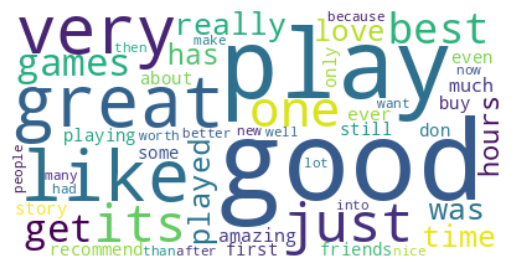

In [49]:
wc = WordCloud(background_color="white", max_words=50)
# generate word cloud
wc.generate_from_frequencies(word_freq)

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
steam_reviews.show(10)

23/10/15 17:50:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , app_id, app_name, review_id, language, review, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
 Schema: _c0, app_id, app_name, review_id, language, review, timestamp_created, timestamp_updated, recommended, votes_helpful, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, author.steamid, author.num_games_owned, author.num_reviews, author.playtime_forever, author.playtime_last_two_weeks, author.playtime_at_review, author.last_played
Expected: _c0 but found: 
CSV file: file:///Users/alexto/Documents/ProgrammingProjects/Tech-Job-Market-Trends/dat

+--------------------+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|                 _c0|app_id|            app_name|review_id|language|                            review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author.steamid|author.num_games_owned|author.num_reviews|author.playtime_forever|author.playtime_last_two_weeks|author.playtime_at_review|author.last_played|
+--------------------+------+--------------------+---------+--------+----------------------------------+-----------------+----------

In [25]:
import pyspark.sql.functions as f
def review_words_cloud(reviews, game: str = None, good_comments_only: bool = None):
  if (game != None):
    reviews = reviews.where(col('app_name') == game)
  
  if (good_comments_only != None):
    if (good_comments_only):
      reviews = reviews.where(col('recommended') == "True")
    else:
      reviews = reviews.where(col('recommended') == "False")
    
  bad_comments_words = reviews.where(col('language') == "english") \
                              .select("app_id", "app_name", "review", explode(split(lower(col("review")), "\W+")).alias("word")) \
                              .where(
                                ~col("word").isin(stopwords) &
                                (length(col("word")) >= 3) &
                                ~col("word").rlike("\d")
                              ) \
                              .select("word") \
                              .groupBy("word").agg(f.count("*").alias("count")) \
                              .orderBy(col("count").desc())


  top_bad_comments_words = bad_comments_words.limit(101).collect()

  word_freq = {}
  for i in range(1, 101):
    row = top_bad_comments_words[i]
    word = row['word']
    count = row['count']
    word_freq[word] = count

    if (i <= 20):
      print(str(i) + ":", word, "(" + str(count) + ")")


  wc = WordCloud(background_color="white", max_words=100)
  wc.generate_from_frequencies(word_freq)

  # show
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.show()

1: good (1499515)
2: play (1092099)
3: great (1051076)
4: like (1046191)
5: very (925678)
6: just (896658)
7: its (831203)
8: one (771972)
9: best (745357)
10: games (739453)
11: get (730989)
12: really (691124)
13: was (678433)
14: time (651351)
15: played (593832)
16: love (575094)
17: has (541660)
18: hours (489063)
19: amazing (472594)
20: ever (462404)


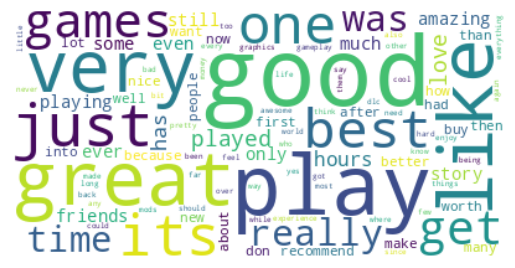

In [26]:
review_words_cloud(steam_reviews)

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


1: good (14020)
2: great (13045)
3: fun (12983)
4: best (10202)
5: one (10169)
6: play (9358)
7: story (9274)
8: very (8133)
9: games (8088)
10: amazing (7045)
11: ever (7039)
12: puzzle (6836)
13: puzzles (6690)
14: played (6324)
15: really (5750)
16: its (5737)
17: just (5736)
18: like (5491)
19: first (5322)
20: love (5181)


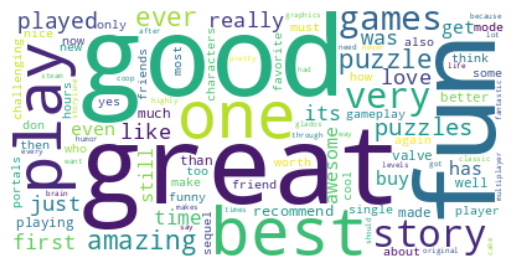

In [27]:
review_words_cloud(steam_reviews, game="Portal 2", good_comments_only=True)

1: portal (121)
2: just (102)
3: play (101)
4: was (82)
5: get (78)
6: its (62)
7: good (59)
8: boring (56)
9: bad (55)
10: fun (53)
11: really (52)
12: first (50)
13: buy (49)
14: valve (49)
15: very (48)
16: because (46)
17: one (46)
18: even (42)
19: after (42)
20: time (42)


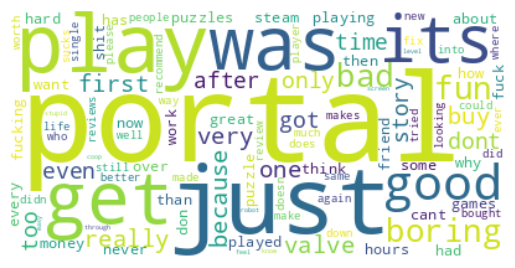

In [28]:
review_words_cloud(steam_reviews, game="Portal 2", good_comments_only=False)